7/2/18:
this is ment to be a temporary notebook where I will experiment with how to run the mimic SOFA score sql code. The code requires having a number of materialized views open, and this is somthing i am unfamiliar with how to handle in jupyter. The purpose of the notebook will be to learn how to utilize these materialized views to run the sofa score script.

upon completion of this, i intend on deleting this file and incorporating the lessons I learn into my labnotebook and my main 03-clinical_variables_streamlined.ipnb notebook

In [164]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 278 ms


In [175]:
# note, all server information is stored in a config.py file that is present in the .gitignore
import importlib
scriptName = 'config.py'
script = importlib.import_module(wd+'/notebooks/PIPELINE/%s' % scriptName)

#import config
conn = psycopg2.connect(dbname=config.dbname, user=config.user, host=config.host, port=config.port,password=config.password)
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

time: 4.29 s


In [7]:
query_schema

'SET search_path to mimiciii;'

time: 3.33 ms


## cohort

In [167]:
#patients of interest from rotation_cohort_generation
final_pt_df2 = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/16072018_final_pt_df2.csv', index_col=0)
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

#'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/08072018_sofa_param_firstday_df.csv'

time: 302 ms


In [179]:
list(final_pt_df2)

['subject_id',
 'icustay_id',
 'hadm_id',
 't_0_sc',
 't_end_sc',
 'ab_course',
 't_0',
 't_end_consec',
 'ICU_admit',
 'dod_hosp',
 'dod_ssn',
 'dod_delta',
 'org_list',
 'spec_type_list',
 'sc_result',
 'final_bin']

time: 7.05 ms


## functions

In [168]:
def sql_exe_show(sql_sentence):
    cur.execute(sql_sentence)
    rows = cur.fetchall()
    col = []
    for i in range(len(cur.description)):
        col.append(cur.description[i][0])
    table = pd.DataFrame(rows,columns=col)
    return table

#input the sql_exe_show object and get dataframe for only patients in patient list out. 
def sql_to_df_icu(sql_exe_show_obj):
    sql_exe_show_df= pd.DataFrame(data=sql_exe_show_obj)
    sql_exe_show_df=sql_exe_show_df[sql_exe_show_df['icustay_id'].isin(icustay_id)]
    return sql_exe_show_df

def sql_to_df_patients(sql_exe_show_obj):
    sql_exe_show_df= pd.DataFrame(data=sql_exe_show_obj)
    sql_exe_show_df=sql_exe_show_df[sql_exe_show_df['subject_id'].isin(patients)]
    return sql_exe_show_df


def sql_to_df_hadm(sql_exe_show_obj):
    sql_exe_show_df= pd.DataFrame(data=sql_exe_show_obj)
    sql_exe_show_df=sql_exe_show_df[sql_exe_show_df['hadm_id'].isin(hadm_id)]
    return sql_exe_show_df

time: 28.9 ms


from the github:
    
How to use code in this folder
This folder generates materialized views for a variety of severity of illness scores (detailed below). The queries make use of materialized views which aggregate data from the first day of a patient's ICU stay. To run the code, it is necessary to:

Run the scripts which generate the constituent materialized views
echodata - generated by /concepts/echo-data.sql
ventdurations - generated by /concepts/durations/ventilation-durations.sql - (needed for subsequent view)
vitalsfirstday - generated by /concepts/firstday/vitals-first-day.sql
uofirstday - generated by /concepts/firstday/urine-output-first-day.sql
ventfirstday - generated by /concepts/firstday/ventilated-first-day.sql
gcsfirstday - generated by /concepts/firstday/gcs-first-day.sql
labsfirstday - generated by /concepts/firstday/labs-first-day.sql
bloodgasfirstday - generated by /concepts/firstday/blood-gas-first-day.sql - (needed for subsequent view)
bloodgasfirstdayarterial - generated by /concepts/firstday/blood-gas-first-day-arterial.sql


for sofa specifically:

--  1) uofirstday - generated by urine-output-first-day.sql
--  2) vitalsfirstday - generated by vitals-first-day.sql
--  3) gcsfirstday - generated by gcs-first-day.sql
--  4) labsfirstday - generated by labs-first-day.sql
--  5) bloodgasfirstdayarterial - generated by blood-gas-first-day-arterial.sql
--  6) echodata - generated by echo-data.sql
--  7) ventdurations - generated by ventilation-durations.sql


Run the script for the severity of illness score you are interested in
OASIS - oasis.sql
SAPS - saps.sql
SOFA - sofa.sql

file location of mimic first day codes (just add on the ending posted above next to each script):
/Users/geickelb1/Documents/GitHub/mimic-code


NOTE: in order to run off dr. Luo's server, i need to add in mimiciii. before each table reference in the script. This appears to be because I don't have write access to the database. 

NOTE2: i will be adjusting the files within the mimic-code folder, but I copied the folder prior to my desktop incase i need to revert these.


In [10]:
# #example of how i've been running my materialized view scripts. 

# f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/ventparam_all48.sql', 'r') 
# ventparamdata = f.read()
# ventparam_all48_sql = ventparamdata#.format(tuple(icustay_id))  
# cur.execute('rollback')
# cur.execute(ventparam_all48_sql)  #I THINK that if i just execute all the scripts that should be sufficient.
# #ventparamTable= sql_exe_show('select * from ventparam_all48;')
# #ventparam_all48_df= sql_to_df_icu(ventparamTable)

time: 1.71 ms


### SOFA materialized views:

In [11]:
#urine output

f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/firstday/urine-output-first-day.sql', 'r') 
#f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/firstday/urine-output-first-day.sql', 'r') 
urine_output_first_day = f.read()
cur.execute('rollback')
cur.execute(urine_output_first_day)

time: 21.6 s


In [169]:
#vitals
f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/firstday/vitals-first-day.sql', 'r')
#f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/firstday/vitals-all.sql', 'r') 
vitals_first_day = f.read()
cur.execute('rollback')
cur.execute(vitals_first_day)

time: 25min 46s


In [186]:
####test, delete after use

#f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/firstday/vitals-first-day.sql', 'r')
f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/firstday/vitals-all.sql', 'r') 
vitalsall = f.read()
cur.execute('rollback')
cur.execute(vitalsall)
vitalsall_table =sql_exe_show('select * from vitalsall;')
vitalsall_df= sql_to_df_icu(vitalsall_table)
#sql_to_df_icu(vitals_all_table).head()

time: 25min 41s


In [191]:
vitalsall_df= sql_to_df_icu(vitalsall_table)
vitalsall_df

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,...,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
7,9,150750,220597,73.0,111.0,85.994819,67.0,240.0,149.716495,47.0,...,16.352423,34.888891,37.888887,36.465466,90.0,100.0,97.338308,92.0,225.0,153.137931
16,19,109235,273430,76.0,114.0,98.416667,118.0,163.0,146.708333,39.0,...,20.583333,36.611112,37.277777,36.873016,96.0,100.0,98.208333,139.0,139.0,139.000000
19,21,111970,216859,61.0,100.0,76.867841,3.0,172.0,103.113043,21.0,...,16.960177,35.722224,37.944446,36.653439,75.0,100.0,95.466667,102.0,349.0,176.820513
24,25,129635,203487,49.0,104.0,76.321839,62.0,165.0,116.344444,28.0,...,18.392857,35.722224,37.666668,36.928105,90.0,100.0,96.373494,59.0,364.0,149.152778
25,26,197661,244882,60.0,86.0,70.580000,89.0,111.0,98.234043,24.0,...,20.060000,36.499998,37.722223,37.161111,96.0,99.0,97.564103,95.0,184.0,131.363636
29,31,128652,254478,44.0,111.0,54.814208,52.0,146.0,102.685864,39.0,...,11.345133,34.555554,39.055557,37.144928,86.0,100.0,97.798995,84.0,177.0,129.166667
31,33,176176,296681,53.0,100.0,64.324324,96.0,130.0,115.000000,41.0,...,16.756757,36.333334,37.444445,36.904040,92.0,99.0,95.459459,92.0,136.0,114.333333
35,36,122659,211200,70.0,152.0,100.784141,60.0,197.0,111.081633,29.0,...,25.796154,35.777779,38.333333,37.157903,38.0,100.0,95.596939,85.0,211.0,114.644444
60,61,176332,252348,73.0,123.0,94.852459,81.0,116.0,91.594595,40.0,...,20.465116,36.666667,38.888889,37.876812,93.0,100.0,97.961538,94.0,161.0,122.857143
62,62,116009,216609,39.0,86.0,52.927711,87.0,127.0,99.012346,45.0,...,22.722892,35.388887,37.111113,36.333333,91.0,100.0,96.600000,84.0,221.0,150.369565


time: 83.4 ms


In [18]:
#gcs
f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/firstday/gcs-first-day.sql', 'r') 
gcs_first_day = f.read()
cur.execute('rollback')
cur.execute(gcs_first_day)

time: 2min 45s


In [19]:
#labs
f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/firstday/labs-first-day.sql', 'r') 
labs_first_day = f.read()
cur.execute('rollback')
cur.execute(labs_first_day)

time: 12min 46s


In [20]:
#bloodgas arterial
f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/firstday/blood-gas-first-day-arterial.sql', 'r') 
blood_gas_arterial_first_day = f.read()
cur.execute('rollback')
cur.execute(blood_gas_arterial_first_day)

time: 3min 27s


In [23]:
#echo

f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/echo-data.sql', 'r') 
echodata = f.read()
#echodata = query_schema + echodata
#gcs_all48_sql = query_schema + gcsdata.format(tuple(patients))
#ventparam_all48_sql = ventparamdata#.format(tuple(icustay_id))  
cur.execute('rollback')
cur.execute(echodata)  #I THINK that if i just execute all the scripts that should be sufficient.
#ventparamTable= sql_exe_show('select * from ventparam_all48;')
#ventparam_all48_df= sql_to_df_icu(ventparamTable)

time: 1min 46s


In [22]:
#vent
f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/durations/ventilation-durations.sql', 'r') 
ventilation_durations_first_day = f.read()
cur.execute('rollback')
cur.execute(ventilation_durations_first_day)

time: 10min 18s


In [177]:
#echodata
echodata_table= sql_exe_show('select * from ECHODATA;')
sql_to_df_patients(echodata_table).head()


,row_id,subject_id,hadm_id,chartdate,charttime,indication,height,weight,bsa,bp,bpsys,bpdias,hr,status,test,doppler,contrast,technicalquality
0,59653,31038,174978.0,2102-06-14,2102-06-14 13:30:00,Endocarditis.,74,165,2.00,102/72,102,72,86,Inpatient,Portable TTE (Complete),Full Doppler and color Doppler,None,Adequate
1,59654,70150,156140.0,2191-05-10,2191-05-10 15:08:00,"CHF, A-FIB",66,263,2.25,107/81,107,81,95,Outpatient,TTE (Complete),Full Doppler and color Doppler,None,Suboptimal
2,59655,54190,188571.0,2158-02-16,2158-02-16 13:48:00,Cerebrovascular event/TIA. Streptococcal bacte...,72,187,2.07,147/87,147,87,90,Inpatient,Portable TEE (Complete),Full Doppler and color Doppler,None,Adequate
3,59656,5771,185291.0,2173-09-02,2173-09-02 09:47:00,78 year-old man with atrial fibrillation off a...,66,130,1.67,163/63,163,63,80,Inpatient,Portable TTE (Complete),Full Doppler and color Doppler,None,Adequate
4,59657,80030,100442.0,2119-06-07,2119-06-07 14:59:00,Left ventricular function.,63,126,1.59,88/53,88,53,115,Inpatient,Portable TTE (Complete),Full Doppler and color Doppler,None,Adequate


time: 2.9 s


# attempting to run sofa

In [24]:
#sofa
f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/severityscores/sofa.sql', 'r') 
sofa = f.read()
cur.execute('rollback')
cur.execute(sofa)
sofaTable= sql_exe_show('select * from SOFA;')
sofa_df= sql_to_df_icu(sofaTable)

time: 1min 24s


In [171]:
sofa_df.head()

,subject_id,hadm_id,icustay_id,sofa,respiration,coagulation,liver,cardiovascular,cns,renal
7,28448,177527,200012,1,NaN,1.0,NaN,0.0,0.0,0.0
12,21789,112486,200019,5,0.0,1.0,NaN,1.0,3.0,0.0
25,9960,159243,200036,8,NaN,1.0,NaN,1.0,4.0,2.0
41,28494,199133,200059,7,0.0,2.0,NaN,4.0,0.0,1.0
46,19891,112840,200065,15,4.0,3.0,1.0,4.0,0.0,3.0


time: 12.9 ms


In [ ]:
#pd.DataFrame(sofa_df).to_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02072018_sofa_firstday_df.csv')

In [49]:
#sofa_parameters
f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/severityscores/sofa_parameters.sql', 'r') 
sofa_parameters = f.read()
cur.execute('rollback')
cur.execute(sofa_parameters)
sofa_parametersTable= sql_exe_show('select * from SOFA_PARAMETERS;')
sofa_parameters_df= sql_to_df_icu(sofa_parametersTable)

KeyboardInterrupt: 

time: 24.4 s


In [90]:
sofa_parameters_df.head()

,subject_id,hadm_id,icustay_id,meanbp_min,rate_norepinephrine,rate_epinephrine,rate_dopamine,rate_dobutamine,creatinine_max,bilirubin_max,platelet_min,pao2fio2_novent_min,pao2fio2_vent_min,urineoutput,mingcs
3,31515,152958,200269,60.000000,NaN,NaN,5.0,NaN,1.4,NaN,147.0,NaN,NaN,360.0,15.0
5,24589,133207,200318,59.666698,0.05,NaN,NaN,NaN,0.9,1.8,109.0,NaN,NaN,2075.0,15.0
7,20190,119413,200375,46.666698,NaN,NaN,3.0,NaN,0.4,0.1,711.0,NaN,220.0,2730.0,14.0
12,24372,106081,200504,54.333302,NaN,NaN,7.5,NaN,1.9,NaN,256.0,NaN,NaN,835.0,8.0
16,28926,103306,200639,55.000000,0.13,NaN,NaN,NaN,1.1,1.1,178.0,NaN,287.5,750.0,15.0


time: 17.7 ms


In [ ]:
var_store2= sofa_test_df - var_store
var_store2.max()# this appears to show that adjusting the day window fom 0 to 1 day to -6hr to 48hr did not change any sofascore parameters... why? 

In [33]:
sofa_parameters_df.loc[sofa_parameters_df.loc[:,"hadm_id"]!=0,:]

,subject_id,hadm_id,icustay_id,meanbp_min,rate_norepinephrine,rate_epinephrine,rate_dopamine,rate_dobutamine,creatinine_max,bilirubin_max,platelet_min,pao2fio2_novent_min,pao2fio2_vent_min,urineoutput,mingcs
3,31515,152958,200269,60.000000,NaN,NaN,5.000000,NaN,1.4,NaN,147.0,NaN,NaN,360.0,15.0
5,24589,133207,200318,59.666698,0.050000,NaN,NaN,NaN,0.9,1.8,109.0,NaN,NaN,2075.0,15.0
7,20190,119413,200375,46.666698,NaN,NaN,3.000000,NaN,0.4,0.1,711.0,NaN,220.000000,2730.0,14.0
12,24372,106081,200504,54.333302,NaN,NaN,7.500000,NaN,1.9,NaN,256.0,NaN,NaN,835.0,8.0
16,28926,103306,200639,55.000000,0.130000,NaN,NaN,NaN,1.1,1.1,178.0,NaN,287.500000,750.0,15.0
20,11320,140887,200891,48.000000,0.300000,NaN,NaN,NaN,2.2,2.3,229.0,NaN,140.000000,1385.0,15.0
24,10076,198503,201006,1.000000,0.128736,NaN,NaN,NaN,0.8,NaN,306.0,NaN,91.666667,895.0,15.0
26,28571,107924,201121,66.000000,0.030000,NaN,NaN,NaN,0.9,0.7,205.0,NaN,NaN,2135.0,15.0
34,4096,124383,201361,44.333302,0.054477,NaN,NaN,NaN,2.8,0.2,340.0,NaN,NaN,491.0,14.0
42,32705,101962,201593,36.000000,1.000000,NaN,NaN,NaN,1.7,1.7,106.0,NaN,NaN,450.0,3.0


time: 42.6 ms


In [35]:
sofa_parameters_df['icustay_id'].nunique()

11493

time: 3.28 ms


In [84]:
#trying to get sofa_parameters without the groupby statements now. adjusting the sql code to remove groupby's. 

#sofa_parameters
f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/severityscores/sofa_parameters_test.sql', 'r') 
sofa_parameters_test = f.read()
cur.execute('rollback')
cur.execute(sofa_parameters_test)
sofa_parameters_test_Table= sql_exe_show('select * from SOFA_PARAMETERS_TEST;')
sofa_parameters_test_df= sql_to_df_icu(sofa_parameters_test_Table)

time: 32.7 s


In [ ]:
#pafi1 & pafi2 parameters
f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/severityscores/sofa_parameters_test.sql', 'r') 
sofa_parameters_test = f.read()
cur.execute('rollback')
cur.execute(sofa_parameters_test)
sofa_parameters_test_Table= sql_exe_show('select * from SOFA_PARAMETERS_TEST;')
sofa_parameters_test_df= sql_to_df_icu(sofa_parameters_test_Table)

# epinephrine explore

In [103]:
#weight durations
f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/weight_durations.sql', 'r') 
weightdurations = f.read()
cur.execute('rollback')
cur.execute(weightdurations)

time: 13 s


In [117]:
#epinephrine extraction to compare
f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/epinephrine_dose.sql', 'r') 
epi_dose = f.read()
cur.execute('rollback')
cur.execute(epi_dose)
epi_dose_Table= sql_exe_show('select * from epinephrine_dose;')
epi_dose_df= sql_to_df_icu(epi_dose_Table)

time: 8.11 s


In [118]:
#EPINEPHRINEDURATIONS

#epinephrine extraction to compare
f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/epinephrine_durations.sql', 'r') 
epi_dur = f.read()
cur.execute('rollback')
cur.execute(epi_dur)
epi_dur_Table= sql_exe_show('select * from EPINEPHRINEDURATIONS;')
epi_dur_df= sql_to_df_icu(epi_dur_Table)

time: 6.12 s


In [119]:
epi_dur_df #n=891
#why is this lower than the other? does the other combine cv and mv?

,icustay_id,vasonum,starttime,endtime,duration_hours
1,200290.0,1,2102-12-24 19:01:00,2102-12-25 02:53:00,7.866667
3,200349.0,1,2139-06-01 19:35:00,2139-06-02 16:31:00,20.933333
4,200349.0,2,2139-06-02 16:31:00,2139-06-02 18:10:00,1.650000
12,200719.0,1,2192-04-24 19:15:00,2192-04-25 04:55:00,9.666667
13,200719.0,2,2192-04-25 06:00:00,2192-04-26 11:30:00,29.500000
18,200952.0,1,2139-09-23 15:07:00,2139-09-24 06:43:00,15.600000
19,200952.0,2,2139-09-25 12:00:00,2139-09-25 21:59:00,9.983333
20,200952.0,3,2139-09-25 21:59:00,2139-09-26 07:38:00,9.650000
21,200952.0,4,2139-09-26 07:38:00,2139-09-26 17:17:00,9.650000
22,200952.0,5,2139-09-26 17:17:00,2139-09-27 02:28:00,9.183333


time: 27 ms


In [120]:
epi_dose_df #n=2216

,icustay_id,starttime,endtime,vaso_rate,vaso_amount
1,200290.0,2102-12-24 19:01:00,2102-12-25 02:53:00,0.040000,1.408524
6,200349.0,2139-06-01 19:35:00,2139-06-02 16:31:00,0.035013,1.998524
7,200349.0,2139-06-02 16:31:00,2139-06-02 18:10:00,0.012030,0.073958
19,200719.0,2192-04-24 19:15:00,2192-04-25 03:30:00,0.020000,0.634074
20,200719.0,2192-04-25 03:30:00,2192-04-25 04:55:00,0.010000,0.061362
21,200719.0,2192-04-25 06:00:00,2192-04-25 10:30:00,0.010000,0.163632
22,200719.0,2192-04-25 10:30:00,2192-04-25 21:00:00,0.005000,0.214767
23,200719.0,2192-04-25 21:00:00,2192-04-26 11:30:00,0.010000,0.593166
31,200952.0,2139-09-23 15:07:00,2139-09-24 06:43:00,0.020004,1.049601
32,200952.0,2139-09-25 12:00:00,2139-09-25 21:59:00,0.080068,1.962759


time: 383 ms


In [121]:
pd.DataFrame(epi_dose_df).to_csv(
    '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/13072018_epi_dose_df.csv')

time: 56.7 ms


In [89]:
sofa_parameters_test_df.loc[sofa_parameters_test_df.loc[:,'charttime'].notnull(),:]

,charttime,cv_rate_norepinephrine,cv_rate_epinephrine,cv_rate_dopamine,cv_rate_dobutamine,icustay_id,starttime,rate_norepinephrine,rate_epinephrine,rate_dopamine,rate_dobutamine
40874,2129-02-19 02:00:00,NaN,NaN,5.0,NaN,203503.0,2129-02-18 15:12:00,NaN,NaN,5.000500,NaN
40875,2129-02-18 16:00:00,NaN,NaN,5.0,NaN,203503.0,2129-02-18 15:12:00,NaN,NaN,5.000500,NaN
40876,2129-02-18 06:45:00,NaN,NaN,2.0,NaN,203503.0,2129-02-18 15:12:00,NaN,NaN,5.000500,NaN
40877,2129-02-18 07:15:00,NaN,NaN,5.0,NaN,203503.0,2129-02-18 15:12:00,NaN,NaN,5.000500,NaN
40878,2129-02-18 14:00:00,NaN,NaN,5.0,NaN,203503.0,2129-02-18 15:12:00,NaN,NaN,5.000500,NaN
40879,2129-02-18 12:45:00,NaN,NaN,5.0,NaN,203503.0,2129-02-18 15:12:00,NaN,NaN,5.000500,NaN
40880,2129-02-18 12:30:00,NaN,NaN,5.0,NaN,203503.0,2129-02-18 15:12:00,NaN,NaN,5.000500,NaN
40881,2129-02-18 12:15:00,NaN,NaN,5.0,NaN,203503.0,2129-02-18 15:12:00,NaN,NaN,5.000500,NaN
40882,2129-02-18 11:00:00,NaN,NaN,5.0,NaN,203503.0,2129-02-18 15:12:00,NaN,NaN,5.000500,NaN
40883,2129-02-18 17:00:00,NaN,NaN,5.0,NaN,203503.0,2129-02-18 15:12:00,NaN,NaN,5.000500,NaN


time: 35.1 ms


In [91]:
pd.DataFrame(sofa_parameters_test_df).to_csv(
    '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/10072018_vaso_all_df.csv')

time: 282 ms


In [29]:
pd.DataFrame(sofa_df).to_csv(
    '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/08072018_sofa_firstday_df.csv')
pd.DataFrame(sofa_parameters_df).to_csv(
    '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/08072018_sofa_param_firstday_df.csv')

time: 241 ms


## takeaways:
    the epinephrine found in the durations.sql file had all of the icustay_id's as the sofa_extracted, but also a lot more. these now will all need to be run for each vaso dilator, and compiled into a new vaso_df.
   

# Compiling all vasodilators.duration.sql files into a vaso_df
- note each sql file still needs to have mimiciii. appended before each call due to the structure of our sever.

In [133]:
#epinephrine dose
f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/epinephrine_dose.sql', 'r') 
epi_dose = f.read()
cur.execute('rollback')
cur.execute(epi_dose)
epi_dose_Table= sql_exe_show('select * from epinephrine_dose;')
epi_dose_df= sql_to_df_icu(epi_dose_Table)

time: 2.38 s


In [132]:
#norepinephrine dose
f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/norepinephrine_dose.sql', 'r') 
norepi_dose = f.read()
cur.execute('rollback')
cur.execute(norepi_dose)
norepi_dose_Table= sql_exe_show('select * from norepinephrine_dose;')
norepi_dose_df= sql_to_df_icu(norepi_dose_Table)

time: 13.2 s


In [134]:
#dopamine dose
f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/dopamine_dose.sql', 'r') 
dopa_dose = f.read()
cur.execute('rollback')
cur.execute(dopa_dose)
dopa_dose_Table= sql_exe_show('select * from dopamine_dose;')
dopa_dose_df= sql_to_df_icu(dopa_dose_Table)

time: 4.98 s


In [135]:
#dobutamine dose
f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/dobutamine_dose.sql', 'r') 
dobu_dose = f.read()
cur.execute('rollback')
cur.execute(dobu_dose)
dobu_dose_Table= sql_exe_show('select * from dobutamine_dose;')
dobu_dose_df= sql_to_df_icu(dobu_dose_Table)

time: 1.45 s


In [153]:
#adding an identification label column and merging them into 1 df. 
epi_dose_df['label']='epinephrine'
norepi_dose_df['label']='norepinephrine'
dopa_dose_df['label']='dopamine'
dobu_dose_df['label']='dobutamine'

vaso_dose_df = pd.concat([epi_dose_df, norepi_dose_df, dopa_dose_df, dobu_dose_df])
pd.DataFrame(vaso_dose_df).to_csv(
    '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/13072018_vaso_dose_df.csv')

time: 503 ms


In [150]:
#vaso_dose_df.head()

,icustay_id,starttime,endtime,vaso_rate,vaso_amount,label
1,200290.0,2102-12-24 19:01:00,2102-12-25 02:53:00,0.040000,1.408524,epinephrine
6,200349.0,2139-06-01 19:35:00,2139-06-02 16:31:00,0.035013,1.998524,epinephrine
7,200349.0,2139-06-02 16:31:00,2139-06-02 18:10:00,0.012030,0.073958,epinephrine
19,200719.0,2192-04-24 19:15:00,2192-04-25 03:30:00,0.020000,0.634074,epinephrine
20,200719.0,2192-04-25 03:30:00,2192-04-25 04:55:00,0.010000,0.061362,epinephrine


time: 9.86 ms


In [151]:
vaso_dose_df.groupby('label')['icustay_id'].nunique()

label
dobutamine         332
dopamine          1081
epinephrine        414
norepinephrine    2912
Name: icustay_id, dtype: int64

time: 12.1 ms


In [152]:
vaso_dose_df['icustay_id'].nunique()

3549

time: 2.82 ms


In [154]:
#WAIT, i didn’t filter for t-6 and t+48 hr. Need to do this!

final_pt_df2.head()

,subject_id,icustay_id,hadm_id,t_0_sc,t_end_sc,ab_course,t_0,t_end_consec,dod_hosp,dod_ssn,dod_delta,org_list,spec_type_list,sc_result,final_bin
0,24915,267059.0,194424,2182-11-29 12:19:00,2182-12-01 00:00:00,full,2182-11-29,2183-01-15,2183-01-15 00:00:00,2183-01-15 00:00:00,0 days 00:00:00.000000000,NaN,NaN,negative,C_neg/A_full
1,24942,278729.0,178112,2159-11-07 17:36:00,2159-11-10 00:00:00,partial,2159-11-08,2159-11-10,NaN,NaN,NaN,NaN,NaN,negative,C_neg/A_partial
2,24968,219670.0,120350,2190-07-31 21:40:00,2190-08-03 00:00:00,partial,2190-08-01,2190-08-02,2190-08-05 00:00:00,2190-08-05 00:00:00,0 days 00:00:00.000000000,NaN,NaN,negative,C_neg/A_partial
3,24776,295185.0,139951,2154-11-10 23:04:00,2154-11-13 00:00:00,full,2154-11-11,2154-11-19,2154-11-23 00:00:00,2154-11-23 00:00:00,0 days 00:00:00.000000000,ESCHERICHIA COLI,URINE,positive,C_pos/A_full
4,24714,211472.0,163632,2193-12-13 10:54:00,2193-12-15 00:00:00,full,2193-12-13,2193-12-26,NaN,NaN,NaN,NaN,NaN,negative,C_neg/A_full


time: 28.5 ms


# MRSA SCREEN INFO

In [161]:
#MRSA screen info
#all positive MRSA screens (need to check if we need only positives or if we want negatives too). this will be used as a clinical variable, rather than for cohort

f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/MRSA_screen.sql', 'r') 
MRSA_screen = f.read()
cur.execute('rollback')
cur.execute(MRSA_screen)
MRSA_screen_Table= sql_exe_show('select * from MRSA_screen;')
MRSA_screen_df= sql_to_df_hadm(MRSA_screen_Table)

#still need to adjust for within the appropriate timeframe.


time: 622 ms


In [162]:
MRSA_screen_df

,subject_id,hadm_id,charttime,chartdate,spec_type_desc,org_name,interpretation
0,31684,102120,2135-06-11 19:29:00,2135-06-11,MRSA SCREEN,None,None
1,31684,102120,2135-06-13 12:06:00,2135-06-13,MRSA SCREEN,None,None
2,31684,102120,2135-06-20 02:43:00,2135-06-20,MRSA SCREEN,None,None
3,31684,102120,2135-06-20 11:41:00,2135-06-20,MRSA SCREEN,None,None
4,31684,102120,2135-06-27 08:39:00,2135-06-27,MRSA SCREEN,None,None
5,31610,198638,2196-03-31 16:27:00,2196-03-31,MRSA SCREEN,None,None
6,31614,125573,2140-02-18 11:36:00,2140-02-18,MRSA SCREEN,None,None
7,31614,125573,2140-02-18 11:37:00,2140-02-18,MRSA SCREEN,None,None
12,30722,188916,2182-09-17 09:41:00,2182-09-17,MRSA SCREEN,None,None
13,30722,188916,2182-09-17 09:41:00,2182-09-17,MRSA SCREEN,None,None


time: 32.4 ms


In [ ]:
print(
    len(patients),
    len(icustay_id),
    len(final_pt_df2)
) #11493

In [ ]:
len(pt_demographics.loc[pt_demographics.loc[:,'subject_id'].isin(patients), :]['subject_id'].unique()) #11493/11493 patients here,
#however 3 of the patients don't have their icustay_id in the icusterile 

# all, non-summary, clinical variable extraction

todo 7/25
- need to redoall of the sql codes, to get all during icu stay. will need to see how large the csv is for viatls. 
 -  might be most efficient to feed list into sql script? since i need a LOT of variables. 
- need to put code on my github, under a new folder with all named -all.sql

In [ ]:
#vitals
f = open('/Users/geickelb1/Documents/GitHub/mimic-code/concepts/firstday/vitals-first-day.sql', 'r')
#f = open('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/clinical_var_sql/firstday/vitals-all.sql', 'r') 
vitalsall = f.read()
cur.execute('rollback')
cur.execute(vitalsall)

In [238]:
vitalsall_df.head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,sysbp_mean,diasbp_min,...,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean,glucose_min,glucose_max,glucose_mean
7,9,150750,220597,73.0,111.0,85.994819,67.0,240.0,149.716495,47.0,...,16.352423,34.888891,37.888887,36.465466,90.0,100.0,97.338308,92.0,225.0,153.137931
16,19,109235,273430,76.0,114.0,98.416667,118.0,163.0,146.708333,39.0,...,20.583333,36.611112,37.277777,36.873016,96.0,100.0,98.208333,139.0,139.0,139.000000
19,21,111970,216859,61.0,100.0,76.867841,3.0,172.0,103.113043,21.0,...,16.960177,35.722224,37.944446,36.653439,75.0,100.0,95.466667,102.0,349.0,176.820513
24,25,129635,203487,49.0,104.0,76.321839,62.0,165.0,116.344444,28.0,...,18.392857,35.722224,37.666668,36.928105,90.0,100.0,96.373494,59.0,364.0,149.152778
25,26,197661,244882,60.0,86.0,70.580000,89.0,111.0,98.234043,24.0,...,20.060000,36.499998,37.722223,37.161111,96.0,99.0,97.564103,95.0,184.0,131.363636


time: 101 ms


Text(0.5,1,'Risk between AB side effect and Infection')

<Figure size 432x288 with 0 Axes>

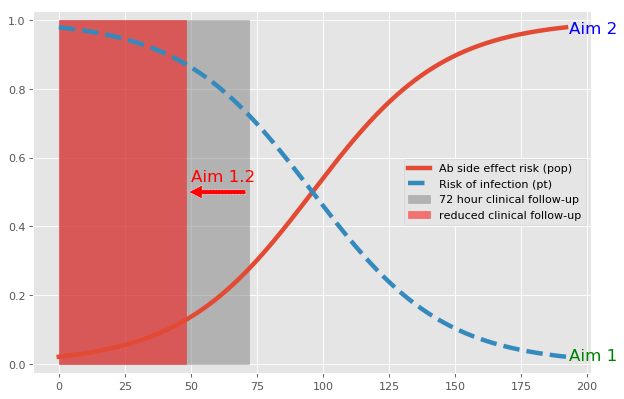

time: 553 ms


In [235]:
from scipy.special import expit
from numpy import exp
import matplotlib.patches as patches

fig = plt.figure()
fig=plt.figure(figsize=(9, 6), dpi= 80, facecolor='w')
ax = plt.axes()

###line parameters and plots
x = np.linspace(0, 192, 1000)
xt=96 #midpoint of the curev
k=0.04 #slope of the curve
L=1 # max y value
ax.plot(x, (L/(1+exp(-k*(x-xt)))), linestyle='-',linewidth=4.0)
ax.plot(x, 1-(L/(1+exp(-k*(x-xt)))), linestyle='--',linewidth=4.0)
#ax.plot(x, 1-(L/(1+exp(-k*(x-75)))), linestyle='--')
#ax.plot([72, 72], [0, 1], color='black', linestyle=':', linewidth=2) #og clinical time
#ax.plot([48, 48], [0, 1], color='red', linestyle=':', linewidth=2) #reduced clinical time

###annotations
ax.annotate('', xy=(72-24, 0.5), xytext=(92-20, 0.5),
            arrowprops=dict(facecolor='red', shrink=0.05, linestyle='--'),
            )

ax.annotate('Aim 1',
            xy=(183, 0.01),
            xytext=(193, 0.01),
            color='green',
            size=15
            )
# ax.annotate('Aim 1.2',
#             xy=(62, 0.49),
#             xytext=(72, 0.49),
#             color='red',
#             size=15,
#             )
ax.annotate('Aim 1.2',
            xy=(40, 0.53),
            xytext=(50, 0.53),
            color='red',
            size=15,
            )

ax.annotate('Aim 2',
            xy=(183, 0.96),
            xytext=(193, 0.96),
            color='blue',
            size=15,
            )

###rectangles
p = patches.Rectangle(
    ([0,0]), 72, 1, fill=True, alpha=.5, color='grey', hatch='')#, fill=False, clip_on=False)
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
ax.add_patch(p) #adds grey rectangle
p = patches.Rectangle(
    ([0,0]), 48, 1, fill=True,alpha=.5, color='red', hatch='')#, fill=False, clip_on=False)
#Rectangle(xy, width, height, angle=0.0, **kwargs)[source]
ax.add_patch(p)

###legend
ax.legend((
    'Ab side effect risk (pop)',
    'Risk of infection (pt)',
    '72 hour clinical follow-up',
    'reduced clinical follow-up'),
    loc= 'best', fontsize='medium')

###plot titles
ax1.set_ylabel('Risk')
ax1.set_xlabel('time')
ax1.set_title('Risk between AB side effect and Infection')


